In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

def truncate(n, dicimals=2):
    return round(n, dicimals)

# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return ">"
    elif A < B:
        return "<"
    else:
        return "="

In [55]:
# For generating Variable C
def generate_gauss_mix(
    N=5000,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class0_0=0,
    mu_class0_1=5,
    mu_class1=1,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class0_0=1,
    sig_class0_1=1,
    sig_class1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class0=None,
    split_class1=None,
):
    class0_mix = True if split_class0 is not None else False
    class1_mix = True if split_class1 is not None else False
    
    prior_0, prior_1 = prior
    p_class0, p_class1 = prior
    n0 = int(N * prior_0)  # number of samples from class 0
    n1 = N - n0  # total number of samples from class 1

    if class1_mix:
        p_class0, p_class1_0, p_class1_1 = (
            prior_0,
            prior_1 * split_class1[0],
            prior_1 * split_class1[1],
        )
        n0 = int(N * p_class0)  # number of samples from class 0
        n1 = N - n0  # total number of samples from class 1
        n1_0 = int(N * p_class1_0)  # number of samples from class 1_0
        n1_1 = n1 - n1_0  # number of samples from class 1_1
        mu_class1_0 = np.array([mu_class1_0] * p)
        mu_class1_1 = np.array([mu_class1_1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1_0 = np.identity(p) * sig_class1_0
        sig_class1_1 = np.identity(p) * sig_class1_1
        x_1_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
        x_1_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
        x_1 = np.vstack((x_1_0, x_1_1))
    else:
        # p_class0, p_class1 = prior
        mu_class1 = np.array([mu_class1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1 = np.identity(p) * sig_class1
        x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

    if class0_mix:
        p_class0_0, p_class0_1 = split_class0
        n0 = int(N * p_class0)
        n0_0 = int(n0 * p_class0_0)
        n0_1 = n0 - n0_0
        mu_class0_0 = np.array([mu_class0_0] * p)
        mu_class0_1 = np.array([mu_class0_1] * p)
        sig_class0_0 = np.identity(p) * sig_class0_0
        sig_class0_1 = np.identity(p) * sig_class0_1
        x_0_0 = np.random.multivariate_normal(mu_class0_0, sig_class0_0, size=n0_0)
        x_0_1 = np.random.multivariate_normal(mu_class0_1, sig_class0_1, size=n0_1)
        x_0 = np.vstack((x_0_0, x_0_1))
    else:
        mu_class0 = np.array([mu_class0] * p)
        x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)

    x = np.vstack((x_0, x_1))
    y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

    # Create the probability density functions (PDFs) for the two Gaussian distributions
    if class0_mix:
        pdf_class0_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class0_1 = multivariate_normal(mu_class1_1, sig_class1_1)
        p_x_given_class0_0 = pdf_class0_0.pdf(x)
        p_x_given_class0_1 = pdf_class0_1.pdf(x)
        p_x_given_class0 = (
            split_class1[0] * p_x_given_class0_0 + split_class0[1] * p_x_given_class0_1
        )
    else:
        pdf_class0 = multivariate_normal(mu_class0, sig_class0)
        p_x_given_class0 = pdf_class0.pdf(x)

    if class1_mix:
        pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
        p_x_given_class1_0 = pdf_class1_0.pdf(x)
        p_x_given_class1_1 = pdf_class1_1.pdf(x)
        p_x_given_class1 = (
            split_class1[0] * p_x_given_class1_0 + split_class1[1] * p_x_given_class1_1
        )
    else:
        pdf_class1 = multivariate_normal(mu_class1, sig_class1)
        p_x_given_class1 = pdf_class1.pdf(x)

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1

    pos_class0 = p_x_given_class0 * p_class0 / p_x
    pos_class1 = p_x_given_class1 * (1 - p_class0) / p_x

    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))

    if class0_mix:
        prior_y_0 = np.array([p_class0_0, p_class0_1])
    else:
        prior_y_0 = np.array(p_class0)

    if class1_mix:
        prior_y_1 = np.array([p_class1_0, p_class1_1])
    else:
        prior_y_1 = np.array(p_class1)
        
    # prior_y = np.vstack((prior_y_0, prior_y_1))

    # entropy_y = entropy(prior_y, base=np.exp(1))
    entropy_y = entropy(prior, base=np.exp(1))
    correlation = np.corrcoef(x_0.T, x_1.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:, 1])
    pauc_90 = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
    pauc_98 = roc_auc_score(y, posterior[:, 1], max_fpr=0.02)
    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = metrics.f1_score(y, y_pred)

    statistics = {
        # 'Correlation': correlation[0,1],
        "Accuracy": accuracy,
        # "F1": f1,
        "MI": MI,
        "AUC": auc,
        # "pAUC_90": pauc_90,
        # "pAUC_98": pauc_98,
        "S@98": tpr_s,
        # 'Sensitivity': sensitivity,
        # 'Specificity': specificity,
        # 'TN': tn,
        # 'FP': fp,
        # 'FN': fn,
        # 'TP': tp
        # "tpr": tpr,
        # "fpr": fpr,
    }
    x_min, x_max = np.min(x), np.max(x)
    xs = np.linspace(x_min - 1, x_max + 1, 1000)
    pdf = pd.DataFrame()
    pdf["x"] = xs
    if class0_mix:
        pdf["pdf_class0"] =  split_class0[0] * pdf_class0_0.pdf(xs) + split_class0[1] * pdf_class0_1.pdf(xs)
    else:
        pdf["pdf_class0"] = pdf_class0.pdf(xs)
    if class1_mix:
        pdf["pdf_class1"] =  split_class1[0] * pdf_class1_0.pdf(xs) + split_class1[1] * pdf_class1_1.pdf(xs)
    else:
        pdf["pdf_class1"] = pdf_class1.pdf(xs)

    return x, y, posterior[:, 1], statistics, pdf

In [56]:
N = 50000
x_A, y_A, posterior_A, statistics_A, pdf_A = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1=1,
    sig_class0=1,
    sig_class1=1,
    split_class1=None,
)

In [57]:
# Generate the data
x_B, y_B, posterior_B, statistics_B, pdf_B = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class1=(0.75, 0.25),
)

In [69]:
# Generate the data
x_C, y_C, posterior_C, statistics_C, pdf_C = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0_0=0,
    mu_class0_1=5,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0_0=1,
    sig_class0_1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class0=(0.75, 0.25),
    split_class1=(0.75, 0.25),
)

\begin{tabular}{lrrr}
\toprule
 & Variable A & Variable B & Variable C \\
\midrule
Accuracy & 0.692240 & 0.623880 & 0.500000 \\
MI & 0.111175 & 0.091953 & 0.000000 \\
AUC & 0.761588 & 0.628235 & 0.500000 \\
S@98 & 0.150160 & 0.264680 & 0.000000 \\
\bottomrule
\end{tabular}



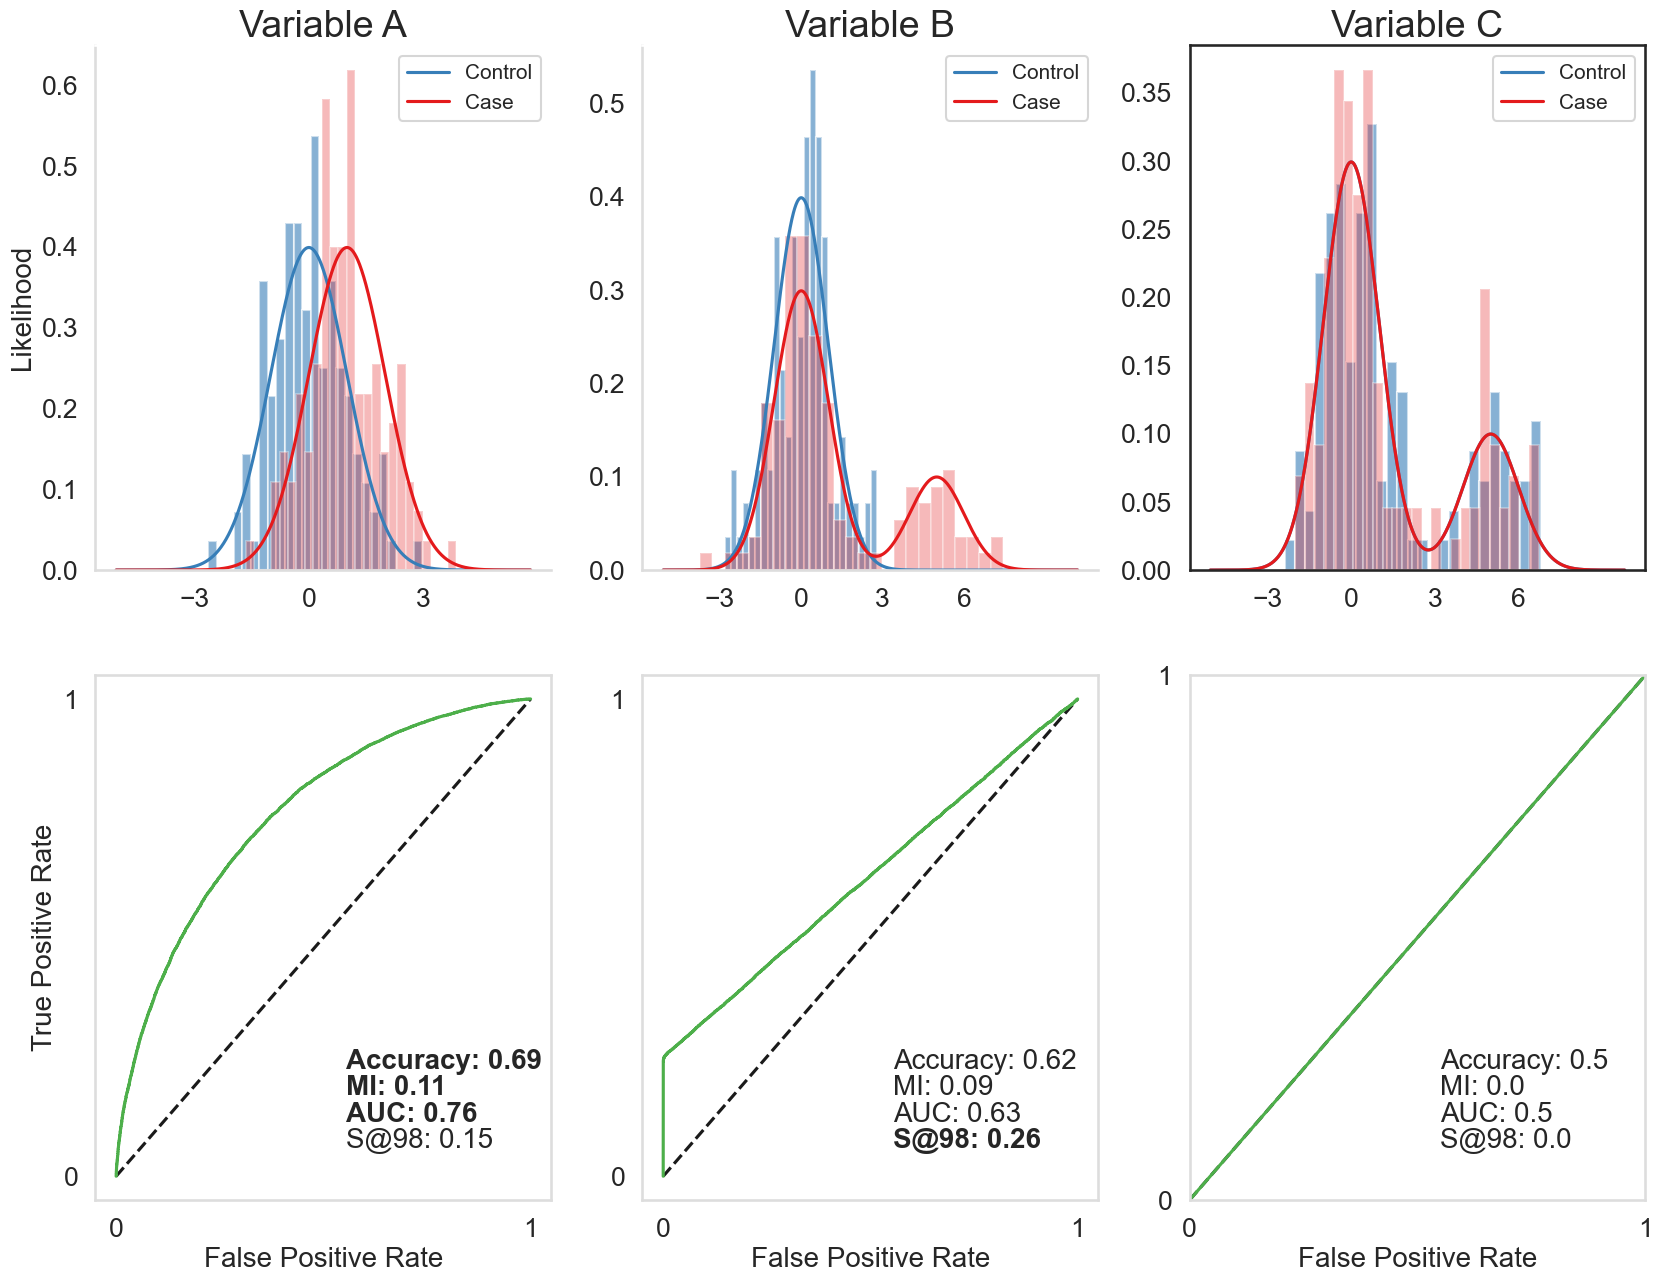

In [89]:
# plot the data
fontsize = 15
tablefontsize = 20
labelsize = 20
density = True
bins = 25
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

# downsample the data to plot the histograms to 250 points each
scale = N // 250
x_A_ = x_A[::scale]
y_A_ = y_A[::scale]
x_B_ = x_B[::scale]
y_B_ = y_B[::scale]
x_C_ = x_C[::scale]
y_C_ = y_C[::scale]
# plot variable A
x_0_A, x_1_A = x_A_[y_A_ == 0], x_A_[y_A_ == 1]
x_0_B, x_1_B = x_B_[y_B_ == 0], x_B_[y_B_ == 1]
x_0_C, x_1_C = x_C_[y_C_ == 0], x_C_[y_C_ == 1]
# x_min, x_max = np.min(x_A), np.max(x_A)
# xs = np.linspace(x_min-1, x_max+1, 1000)

# set the ticks size for all the plots
for i in range(2):
    for j in range(3):
        ax[i, j].tick_params(labelsize=labelsize - 1)

ax[0, 0].hist(x_0_A, bins=bins, density=density, alpha=0.6, color=PALETTE[1])
ax[0, 0].hist(x_1_A, bins=bins, density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_A, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 0]
)
sns.lineplot(pdf_A, x="x", y="pdf_class1", label="Case", color=PALETTE[0], ax=ax[0, 0])
# Set the axis labels
ax[0, 0].set_title("Variable A")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("Likelihood", fontsize=labelsize)
ax[0, 0].legend(fontsize=fontsize)
# set the xticks to just min and max
ax[0, 0].set_xticks([int(np.min(x_0_A)) - 1, 0, -(int(np.min(x_0_A)) - 1)])
ax[0,0].spines['left'].set_color('#dddddd')
ax[0,0].spines['right'].set_color('#dddddd')
ax[0,0].spines['top'].set_color('#dddddd')
ax[0,0].spines['bottom'].set_color('#dddddd')

ax[0, 1].hist(x_0_B, bins=bins, density=density, alpha=0.6, color=PALETTE[1])
ax[0, 1].hist(x_1_B, bins=bins, density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_B, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 1]
)
sns.lineplot(pdf_B, x="x", y="pdf_class1", label="Case", color=PALETTE[0], ax=ax[0, 1])
ax[0, 1].set_title("Variable B")
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("")
ax[0, 1].legend(fontsize=fontsize)
# set the xtiks to integers
# ax[0, 1].set_xticks(np.arange(-6, 9, 2))
ax[0, 1].set_xticks(
    [
        int(np.min(x_0_B)) - 1,
        0,
        -(int(np.min(x_0_B)) - 1),
        -(int(np.min(x_0_B)) - 1) * 2,
    ]
)
ax[0,1].spines['left'].set_color('#dddddd')
ax[0,1].spines['right'].set_color('#dddddd')
ax[0,1].spines['top'].set_color('#dddddd')
ax[0,1].spines['bottom'].set_color('#dddddd')

ax[0, 2].hist(x_0_C, bins=bins, density=density, alpha=0.6, color=PALETTE[1])
ax[0, 2].hist(x_1_C, bins=bins, density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_C, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 2]
)
sns.lineplot(pdf_C, x="x", y="pdf_class1", label="Case", color=PALETTE[0], ax=ax[0, 2])
ax[0, 2].set_title("Variable C")
ax[0, 2].set_xlabel("")
ax[0, 2].set_ylabel("")
ax[0, 2].legend(fontsize=fontsize)
ax[0, 2].set_xticks(
    [
        int(np.min(x_0_C)) - 1,
        0,
        -(int(np.min(x_0_C)) - 1),
        -(int(np.min(x_0_C)) - 1) * 2,
    ]
)
ax[0,2].spines['left'].set_color('#dddddd')
ax[0,2].spines['right'].set_color('#dddddd')
ax[0,2].spines['top'].set_color('#dddddd')
ax[0,2].spines['bottom'].set_color('#dddddd')

# plot the ROC curve
# convert the fpr, tpr, thresholds in a dataframe
fpr_A, tpr_A, thresholds_A = metrics.roc_curve(
    y_A, posterior_A, pos_label=1, drop_intermediate=False
)
fpr_B, tpr_B, thresholds_B = metrics.roc_curve(
    y_B, posterior_B, pos_label=1, drop_intermediate=False
)
fpr_C, tpr_C, thresholds_C = metrics.roc_curve(
    y_C, posterior_C, pos_label=1, drop_intermediate=False
)
df_roc_A = pd.DataFrame({"fpr": fpr_A, "tpr": tpr_A, "thresholds": thresholds_A})
df_roc_B = pd.DataFrame({"fpr": fpr_B, "tpr": tpr_B, "thresholds": thresholds_B})
df_roc_C = pd.DataFrame({"fpr": fpr_C, "tpr": tpr_C, "thresholds": thresholds_C})

# plot the ROC curve
# remove the padding from the subplots


ax[1, 0].set_xlabel("False Positive Rate", fontsize=labelsize)
ax[1, 0].set_ylabel("True Positive Rate", fontsize=labelsize)
# ax[1, 0].set_title("ROC Curve: Variable A")
ax[1, 0].plot([0, 1], [0, 1], "k--", label="Random")
ax[1, 0].plot(df_roc_A["fpr"], df_roc_A["tpr"], color=PALETTE[2])
# set the ticks to 0, 1
ax[1, 0].set_xticks([0, 1])
ax[1, 0].set_yticks([0, 1])

ax[1,0].spines['left'].set_color('#dddddd')
ax[1,0].spines['right'].set_color('#dddddd')
ax[1,0].spines['top'].set_color('#dddddd')
ax[1,0].spines['bottom'].set_color('#dddddd')

ax[1, 1].set_xlabel("False Positive Rate", fontsize=labelsize)
ax[1, 1].set_ylabel("")
# ax[1, 1].set_title("ROC Curve: Variable B")
ax[1, 1].plot([0, 1], [0, 1], "k--", label="Random")
ax[1, 1].plot(df_roc_B["fpr"], df_roc_B["tpr"], color=PALETTE[2])
ax[1, 1].set_xticks([0, 1])
ax[1, 1].set_yticks([0, 1])

ax[1,1].spines['left'].set_color('#dddddd')
ax[1,1].spines['right'].set_color('#dddddd')
ax[1,1].spines['top'].set_color('#dddddd')
ax[1,1].spines['bottom'].set_color('#dddddd')

ax[1, 2].set_xlabel("False Positive Rate", fontsize=labelsize)
ax[1, 2].set_ylabel("")
# ax[1, 2].set_title("ROC Curve: Variable C")
ax[1, 2].plot([0, 1], [0, 1], "k--", label="Random")
ax[1, 2].plot(df_roc_C["fpr"], df_roc_C["tpr"], color=PALETTE[2])
ax[1, 2].set_xticks([0, 1])
ax[1, 2].set_yticks([0, 1])

ax[1,2].spines['left'].set_color('#dddddd')
ax[1,2].spines['right'].set_color('#dddddd')
ax[1,2].spines['top'].set_color('#dddddd')
ax[1,2].spines['bottom'].set_color('#dddddd')



statistics_A_list = np.array(list(statistics_A.values()))
statistics_B_list = np.array(list(statistics_B.values()))
statistics_C_list = np.array(list(statistics_C.values()))
df = pd.DataFrame(
    np.vstack((statistics_A_list, statistics_B_list, statistics_C_list)).T,
    index=statistics_A.keys(),
    columns=["Variable A", "Variable B", "Variable C"],
)
winners = df.idxmax(axis=1)
# print the statistics
for i, (key, value) in enumerate(statistics_A.items()):
    if winners[key] == "Variable A":
        fontweight = "bold"
    else:
        fontweight = "normal"
    ax[1, 0].text(
        0.55,
        0.25 - i * 0.05,
        f"{key}: {truncate(value)}",
        fontsize=tablefontsize,
        transform=ax[1, 0].transAxes,
        fontweight=fontweight,
    )
for i, (key, value) in enumerate(statistics_B.items()):
    if winners[key] == "Variable B":
        fontweight = "bold"
    else:
        fontweight = "normal"
    ax[1, 1].text(
        0.55,
        0.25 - i * 0.05,
        # bold the value if it is greater than the value in the previous variable
        f"{key}: {truncate(value)}",
        fontsize=tablefontsize,
        transform=ax[1, 1].transAxes,
        fontweight=fontweight,
    )

for i, (key, value) in enumerate(statistics_C.items()):
    if winners[key] == "Variable C":
        fontweight = "bold"
    else:
        fontweight = "normal"
    ax[1, 2].text(
        0.55,
        0.25 - i * 0.05,
        f"{key}: {truncate(value)}",
        fontsize=tablefontsize,
        transform=ax[1, 2].transAxes,
        fontweight=fontweight,
    )

# plt.subplots_adjust(top=1, bottom=0, right=2, left=1, hspace=1, wspace=1)
plt.margins(0, 0)

print(df.to_latex())

In [51]:
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & Variable A & Variable B & Variable C \\
\midrule
Accuracy & 0.690840 & 0.623880 & 0.500000 \\
MI & 0.111722 & 0.092091 & 0.000000 \\
AUC & 0.760926 & 0.628680 & 0.500000 \\
S@98 & 0.145040 & 0.264120 & 0.000000 \\
\bottomrule
\end{tabular}

